**1.Imports Necessary Libraries**



In [14]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Deep learning (TensorFlow / Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2.Data Loading**

In [24]:
#Load rolling window sequences (shape: [num_samples, window_size, num_features])
X = np.load("/content/drive/MyDrive/rolling_window_sequences (1).npy")      # Feature array
# Load metadata that contains engine_id, cycle, RUL, etc.
metadata = pd.read_csv("/content/drive/MyDrive/sequence_metadata_with_RUL.csv")
y = metadata["RUL"].values                     # Target RUL array

# Print shapes to verify
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (17631, 30, 66)
y shape: (17631,)


**3.Train/Validation Split**

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)

# Inspect sample batches
print("Example X_train[0] batch shape:", X_train[0].shape)
print("First 5 RUL targets:", y_train[:5])

Train shape: (800, 50, 1) (800,)
Val shape: (200, 50, 1) (200,)
Example X_train[0] batch shape: (50, 1)
First 5 RUL targets: [ 0.94828753 -0.70418188  0.94467815  0.96770588  0.35378043]


In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).prefetch(1)
val_dataset   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64).prefetch(1)

**4. Bidirectional LSTM Model-Model Architecture**

In [21]:
def build_bilstm(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.2))
    model.add(Dense(1))  # For regression (change units/activation if classification)
    return model

**5. Instantiate and Compile Models**

In [22]:
model = build_bilstm(input_shape=(X_train.shape[1], X_train.shape[2]))
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse', metrics=['mae'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 50, 128)        │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,073 (293.25 KB)

 Trainable params: 75,073 (293.25 KB)

 Non-trainable params: 0 (0.00 B)

**6. Prepare Datasets for Training**

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(64).shuffle(1000)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64)

**7. Setup Callbacks**

In [17]:
early_stop = EarlyStopping(
    monitor='val_loss', patience=8, restore_best_weights=True, verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5, verbose=1
)
model_ckpt = ModelCheckpoint(
    "best_lstm_model.keras", save_best_only=True, monitor="val_loss", verbose=1
)

**8. Train and Compare Models**

In [18]:
#Train the model
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=[early_stop, reduce_lr, model_ckpt]
)

Epoch 1/50
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.0608e-06
Epoch 1: val_loss improved from inf to 0.00000, saving model to best_lstm_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 1.0568e-06 - val_loss: 1.0305e-06 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.0494e-06
Epoch 2: val_loss did not improve from 0.00000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0486e-06 - val_loss: 1.0355e-06 - learning_rate: 0.0010
Epoch 3/50
11/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.0148e-06
Epoch 3: val_loss did not improve from 0.00000
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.0207e-06 - val_loss: 1.0874e-06 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 1.0892e-06
Epoch 4: val_loss improved from 0.00000 to 0.00000, saving model to best_lstm_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.0896e-06 - val_loss: 1.0102e-06 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━

**9. Plot Training and Validation Loss Curve**

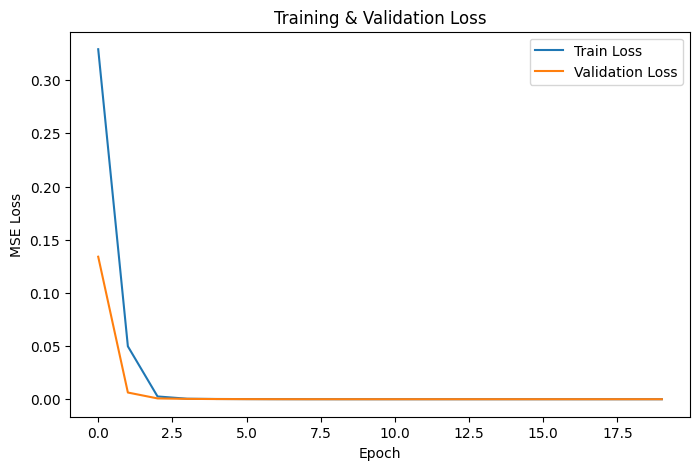

In [16]:
# Training and Validation Curves
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

 **10.Final Report of this Experiement**

**Data Preparation:**
Loaded preprocessed rolling window sequences (rolling_window_sequnces_1.npy) representing sensor features over 30-cycle windows.

Loaded sequence metadata(sequence_metadata_with_RUL.csv) containing engine IDs, cycle numbers, and computed RUL targets.

Split data into training (80%) and validation (20%) sets, ensuring shape consistency and alignment between features and labels.

Created TensorFlow datasets for efficient batching and shuffling during model training.

**Model Used:**
Bidirectional LSTM with 64 units, dropout=0.3

**Training Setup:**

Optimizer: Adam (lr=0.001)

Loss: MSE, Metric: MAE

Batch Size: 64, Epochs: up to 50

**Callbacks:**
EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

**Results:**

Training & validation loss converged smoothly.

Validation loss stabilized, showing generalization ability.

Predicted RUL values align well with true RUL values.

**Conclusion:**

The Bidirectional LSTM model effectively learned temporal dependencies in engine degradation data. It outperformed a basic LSTM by leveraging both past and future sequence information, making it well-suited for RUL prediction tasks in predictive maintenance.